In [14]:
import re, sys
print("{:15s} {}".format("python", re.sub(r' \|(\n|.)*', '', sys.version)))
import IPython
print("{:15s} {}".format("IPython", IPython.__version__))
import matplotlib
print("{:15s} {}".format("matplotlib", matplotlib.__version__))
import networkx
print("{:15s} {}".format("networkx", networkx.__version__))
import nltk
print("{:15s} {}".format("nltk", nltk.__version__))
import numpy
print("{:15s} {}".format("numpy", numpy.__version__))
import pandas
print("{:15s} {}".format("pandas", pandas.__version__))
import pickle
print("{:15s} {}".format("pickle", pickle.format_version))
import scipy
print("{:15s} {}".format("scipy", scipy.__version__))
import seaborn
print("{:15s} {}".format("seaborn", seaborn.__version__))
import sklearn
print("{:15s} {}".format("sklearn", sklearn.__version__))
import jupyter_core
print("{:15s} {}".format("jupyter_core", jupyter_core.__version__))
import jupyter_client
print("{:15s} {}".format("jupyter_client", jupyter_client.__version__))
import notebook
print("{:15s} {}".format("notebook", notebook.__version__))
import jupyterlab
print("{:15s} {}".format("jupyterlab", jupyterlab.__version__))

python          3.6.2
IPython         6.1.0
matplotlib      2.0.2
networkx        1.11
nltk            3.3
numpy           1.13.1
pandas          0.20.3
pickle          4.0
scipy           0.19.1
seaborn         0.7.1
sklearn         0.18.2
jupyter_core    4.3.0
jupyter_client  5.1.0
notebook        5.0.0
jupyterlab      0.27.0


---

_You are currently looking at **version 1.2** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 4

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
P1_Graphs = pickle.load(open('A4_graphs','rb'))
P1_Graphs

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs and determine which of the three algorithms generated the graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

In [3]:
def graph_identification():
    
    x = []
    for G in P1_Graphs:
        degrees = G.degree()
        degree_values = sorted(set(degrees.values()))
        cluster = nx.average_clustering(G)
        shortest_path = nx.average_shortest_path_length(G)
        #print(len(degree_values), cluster, shortest_path)
        if len(degree_values)>10:
            x.append('PA')
        elif cluster <0.1:
            x.append('SW_H')
        else: x.append('SW_L')
    
    return x

In [4]:
graph_identification = graph_identification()
graph_identification

['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

---

## Part 2 - Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [5]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


<IPython.core.display.Javascript object>


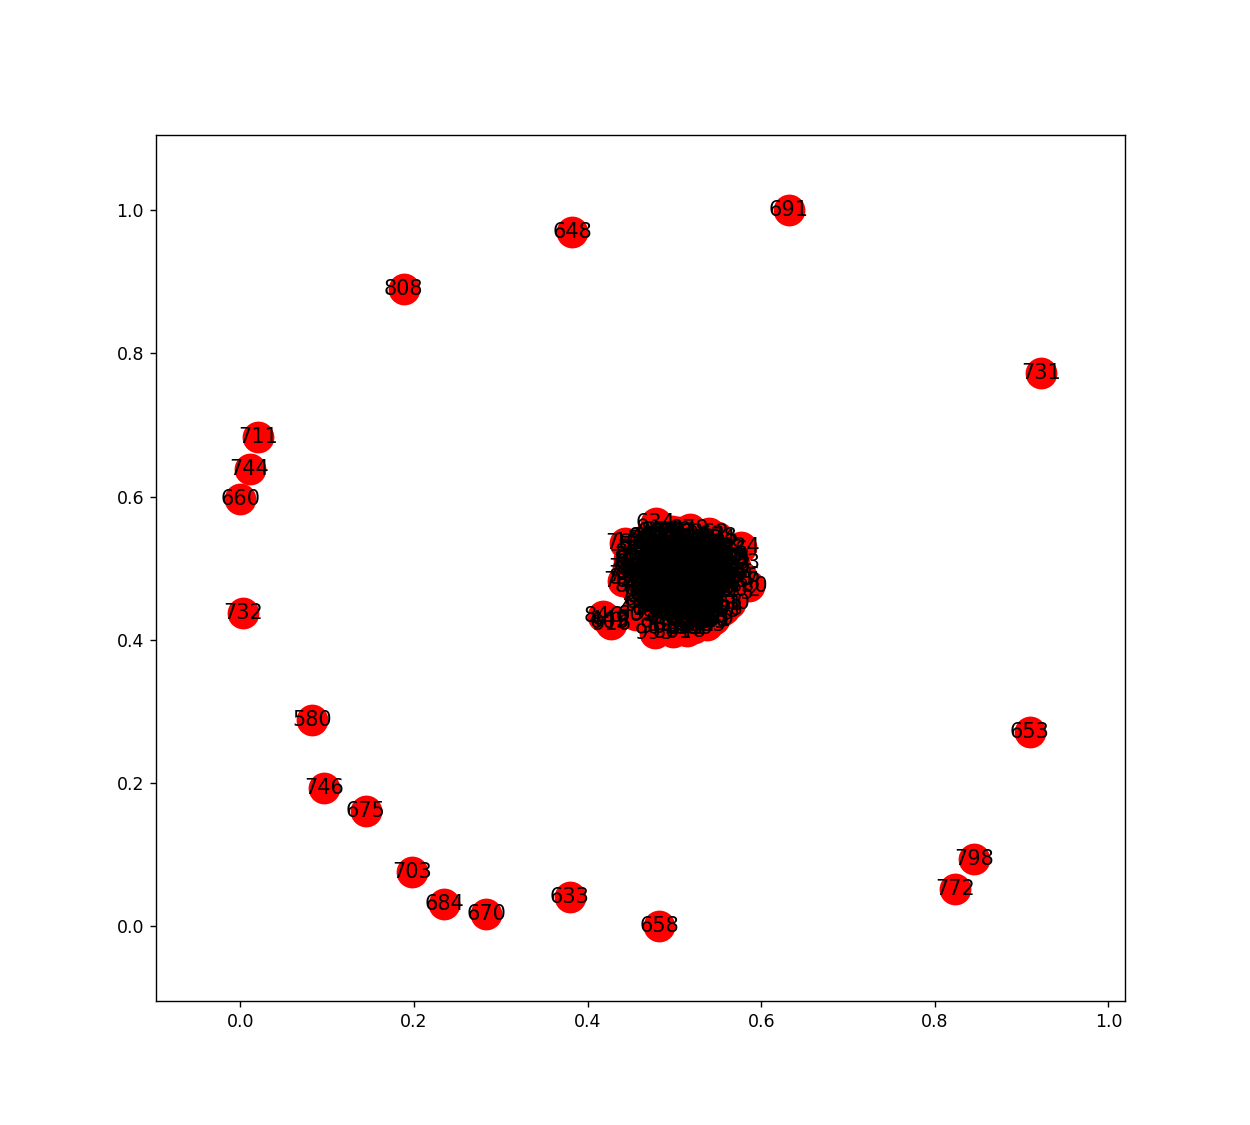

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
nx.draw_networkx(G)

### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 252 with the data being the probability of receiving management salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [6]:
def salary_predictions():
    
    node ={}
    Department = {}
    ManagementSalary = {}
    for i in range(0, len(G.nodes(data=True))):
        node[i]= G.nodes(data=True)[i][0]
        Department[i]=G.nodes(data=True)[i][1]['Department']
        ManagementSalary[i]=G.nodes(data=True)[i][1]['ManagementSalary']
    
    df = pd.DataFrame()
    df['node'] = pd.Series(node)
    df['Department'] = pd.Series(Department)
    df['clustering'] = pd.Series(nx.clustering(G))
    df['degree'] = pd.Series(G.degree())
    df['degree_centrality'] = pd.Series(nx.degree_centrality(G))
    df['closeness'] = pd.Series(nx.closeness_centrality(G, normalized=True))
    df['betweeness'] = pd.Series(nx.betweenness_centrality(G, normalized=True))
    df['pr'] = pd.Series(nx.pagerank(G))
    df['Salary'] = pd.Series(ManagementSalary)
    #df
    df_train = df[~pd.isnull(df['Salary'])]
    X_predict = df[pd.isnull(df['Salary'])].iloc[:,:-1]
    X_train = df_train[['node', 'Department', 'clustering',  'degree', 'degree_centrality', 'closeness', 'betweeness' ,'pr']]
    y_train = df_train['Salary']

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)
    
    from sklearn.ensemble import  GradientBoostingClassifier

    clf = GradientBoostingClassifier(criterion ='friedman_mse',  n_estimators=500, max_depth=3, 
                                 min_samples_split=2, learning_rate=0.1, random_state = 0, 
                                max_features = 'log2').fit(X_train, y_train)
    x= clf.predict_proba(X_predict)[:,1]
    return pd.Series(x, index = X_predict['node'])

In [7]:
salary_predictions = salary_predictions()
salary_predictions

node
1       1.205809e-06
2       9.999870e-01
5       9.999916e-01
8       1.035407e-02
14      2.555221e-04
18      1.200445e-04
27      1.130026e-03
30      9.970876e-01
31      4.713400e-03
34      1.873230e-04
37      2.716646e-03
40      1.400295e-04
45      7.791925e-06
54      9.164090e-03
55      6.157653e-02
60      4.760642e-02
62      9.999719e-01
65      9.998929e-01
77      1.096437e-05
79      1.908374e-05
97      1.073500e-04
101     1.274886e-06
103     2.312683e-02
108     1.764455e-05
113     5.750723e-04
122     2.253497e-07
141     1.718035e-02
142     9.999789e-01
144     1.024122e-03
145     9.903089e-01
            ...     
913     2.245967e-04
914     1.397858e-04
915     3.879298e-07
918     2.011425e-04
923     1.075703e-03
926     5.809438e-03
931     3.274119e-05
934     1.069044e-08
939     2.078481e-07
944     1.237941e-07
945     3.992209e-04
947     1.687554e-02
950     3.268512e-04
951     4.909461e-06
953     1.889773e-06
959     3.190176e-07
962     

### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [8]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [9]:
def new_connections_predictions():
    
    PA = list(nx.preferential_attachment(G))
    df = pd.DataFrame(index=[(x[0], x[1]) for x in PA])
    df['PA'] = [x[2] for x in PA]
    #df['MCN'] = [len(list(nx.common_neighbors(G, x[0], x[1]))) for x in df.index.values]
    #df['RAI'] = [x[2] for x in list(nx.resource_allocation_index(G))]
    df['JC'] = [x[2] for x in list(nx.jaccard_coefficient(G))]
    #df['AA'] = [x[2] for x in list(nx.adamic_adar_index(G))]
    
    #df['CN'] = [x[2] for x in list(nx.cn_soundarajan_hopcroft(G, community='Department'))]
    #df["RA"] = [x[2] for x in list(nx.ra_index_soundarajan_hopcroft(G, community='Department'))]
    
    same_dep = []
    for x, y, z in PA:
        if G.node[x]['Department'] == G.node[y]['Department']:
            same_dep.append(1)
        else: same_dep.append(0)
    df['same_dep'] = same_dep
    
    df = future_connections.merge(df, left_index=True, right_index=True)
    df = df[['PA','JC','same_dep', 'Future Connection' ]] #'AA','MCN','RAI','JC',

    df_train = df[~pd.isnull(df['Future Connection'])]
    X_predict = df[pd.isnull(df['Future Connection'])].iloc[:,:-1]
    X_train = df_train[['PA', 'JC', 'same_dep' ]]
    y_train = df_train['Future Connection']
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)
    
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression( ).fit(X_train, y_train)
    x= clf.predict_proba(X_predict)[:,1]

    return pd.Series(x, index = X_predict.index)

In [10]:
new_connections_predictions()

(107, 348)    0.018020
(542, 751)    0.009477
(20, 426)     0.505636
(50, 989)     0.009216
(942, 986)    0.008945
(324, 857)    0.009252
(13, 710)     0.121323
(19, 271)     0.298290
(319, 878)    0.009128
(659, 707)    0.009449
(49, 843)     0.009049
(208, 893)    0.009386
(377, 469)    0.031427
(405, 999)    0.012192
(129, 740)    0.014736
(292, 618)    0.021775
(239, 689)    0.009110
(359, 373)    0.018870
(53, 523)     0.225278
(276, 984)    0.009062
(202, 997)    0.009010
(604, 619)    0.453173
(270, 911)    0.009115
(261, 481)    0.100079
(200, 450)    0.895825
(213, 634)    0.009559
(644, 735)    0.159982
(346, 553)    0.010254
(521, 738)    0.011764
(422, 953)    0.021105
                ...   
(672, 848)    0.009115
(28, 127)     0.610011
(202, 661)    0.010378
(54, 195)     0.999540
(295, 864)    0.009292
(814, 936)    0.009518
(839, 874)    0.008945
(139, 843)    0.009269
(461, 544)    0.012973
(68, 487)     0.013199
(622, 932)    0.009355
(504, 936)    0.024811
(479, 528) 